In [22]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Reshape, LSTM, LeakyReLU
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from scipy.stats import multivariate_normal
import math
import os
import random
import pickle
import tensorflow as tf
#which gpu is available?
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [23]:
#block to get reproducible results
seed_value=1
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [24]:
#import dataset
dataset=pd.read_csv('../../MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv')
dataset_1=pd.read_csv('../../MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv')
dataset_2=pd.read_csv('../../MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
dataset_3=pd.read_csv('../../MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
dataset_4=pd.read_csv('../../MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
dataset_5=pd.read_csv('../../MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
dataset_6=pd.read_csv('../../MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv')
dataset_7=pd.read_csv('../../MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv')

In [25]:
dataset=dataset.append(dataset_1, ignore_index=True)
dataset=dataset.append(dataset_2, ignore_index=True)
dataset=dataset.append(dataset_3, ignore_index=True)
dataset=dataset.append(dataset_4, ignore_index=True)
dataset=dataset.append(dataset_5, ignore_index=True)
dataset=dataset.append(dataset_6, ignore_index=True)
dataset=dataset.append(dataset_7, ignore_index=True)

In [26]:
dataset.head()
dataset[dataset==np.inf]=np.nan
dataset.fillna(0,inplace=True)
x_dataset=dataset.iloc[:, :-1]
y=dataset.iloc[:, -1]

In [27]:
le=LabelEncoder()
y_encoded=le.fit_transform(y)
# le.classes_

In [28]:
scaler=MinMaxScaler()
x_dataset_scaled=scaler.fit_transform(x_dataset)

In [29]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

In [30]:
#FIND OUT INDICES OF Y AND X THAT ARE ONLY NORMAL AND DIVIDE intow two parts
y_normal_indices=np.where(y_encoded==0)
y_normal_indices_list=np.array_split(y_normal_indices[0],2)
y_normal_train=y_encoded[y_normal_indices_list[0]]
y_normal_test=y_encoded[y_normal_indices_list[1]]
x_normal_train=x_dataset_scaled[y_normal_indices_list[0]]
x_normal_test=x_dataset_scaled[y_normal_indices_list[1]]
print(len(y_normal_train), len(y_normal_test), len(x_normal_train), len(x_normal_test))

1136549 1136548 1136549 1136548


In [31]:
y_val,y_count = np.unique(y_encoded, return_counts=True) 
y_retained = y_val[y_count>100]
y_attacks = y_retained[y_retained>0]

accs = []
cfs = []
y_attacks

array([ 1,  2,  3,  4,  5,  6,  7, 10, 11, 12, 14])

In [32]:
for n_attacks_train in y_attacks:
    #find the training attacks
    y_train_indices=np.where(y_encoded==n_attacks_train)

    y_attack_train=np.ones(len(y_train_indices[0]),dtype=int)  
    #find the x_dataset corr to this
    x_attack_train=x_dataset_scaled[y_train_indices[0]]
    
    
    #create the training data
    x_train=np.concatenate([x_attack_train,x_normal_train])
    y_train=np.concatenate([y_attack_train,y_normal_train])
    
    print("Length of y_attack_test",len(y_attack_train))
    n=(int)(len(y_normal_train)/len(y_attack_train))
    print(n)
    for i in range(n-1):
        x_train=np.concatenate([x_train,x_attack_train])
        y_train=np.concatenate([y_train,y_attack_train])
        
    print("XTRAIN_TRAINLEN", len(x_train),len(y_train))
    
    # Need to declare it every time, otherwise it gets erased from memory
    def cldnn():
          #FILL THIS IN WITH MODEL ARCHITECTURE
        model = Sequential()
        model.add(Conv2D(256,(1,3),activation="relu",input_shape =(2,39,1)))
        model.add(Conv2D(256,(2,3),activation=None))
        model.add(LeakyReLU(0.3))
        model.add(Conv2D(256,(1,3),activation=None))
        model.add(LeakyReLU(0.3))
        model.add(Dropout(0.20))
        model.add(Conv2D(80,(1,3),activation="relu"))
        model.add(Reshape((31,80)))
        model.add(Flatten())
        model.add(Dense(128,activation="relu",kernel_initializer="normal"))
        model.add(Dense(2,activation="sigmoid"))
        model.summary()
        return model
        
    cldnn = cldnn()
    cldnn.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
    
    x_train_examples,_=x_train.shape
    Y_train = to_onehot(y_train)
    X_train = x_train.reshape(x_train_examples, 2, 39, 1)
        
    cldnn_mdata=cldnn.fit(X_train,Y_train,validation_split=0.2,epochs=20,batch_size =1024,shuffle=True)
    
    for n_attacks_test in y_attacks:
        print(n_attacks_train, n_attacks_test)

        #find the testing attacks
        if n_attacks_test== n_attacks_train:
            continue
        else:
            y_test_indices=np.where(y_encoded==n_attacks_test)
            y_test_indices=y_test_indices[0] 
        
        y_attack_test=np.ones(len(y_test_indices),dtype=int)
        
        print(len(x_train),len(y_train[y_train==0]),len(y_train[y_train==1]))
            
        #find the x_dataset corr to this
        x_attack_test=x_dataset_scaled[y_test_indices]

        #create the testing data
        x_test=np.concatenate([x_attack_test,x_normal_test])
        y_test=np.concatenate([y_attack_test,y_normal_test])   
    
        #print("TRAINING", len(y_train),len(y_train[y_train==0]), len(y_train[y_train==1]))
        #print("TESTING", len(y_test),len(y_test[y_test==0]), len(y_test[y_test==1]))   
        
        
        x_test_examples,_= x_test.shape
                
        
        Y_test = to_onehot(y_test)
        X_test = x_test.reshape(x_test_examples, 2, 39, 1)

        scores=cldnn.evaluate(X_test,Y_test)
        
        print(n_attacks_train, n_attacks_test)
        print("Accuracy:%.2f%%"%(scores[1]*100))
        
        accs.append(scores[1])
        
        y_pred=cldnn.predict(X_test)
        y_label=np.argmax(y_pred,axis=-1)
        cf=confusion_matrix(y_test,y_label)
        
        cfs.append(cf)

Length of y_attack_test 1966
578
XTRAIN_TRAINLEN 2272897 2272897
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2, 37, 256)        1024      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 35, 256)        393472    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1, 35, 256)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 33, 256)        196864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 33, 256)        0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 33, 256)        0         
_________________________________________________________

1773/1773 [==============================] - 77s 44ms/step - loss: 5.8352e-04 - accuracy: 0.9998 - val_loss: 8.7611e-04 - val_accuracy: 0.9998
Epoch 14/20
1773/1773 [==============================] - 77s 44ms/step - loss: 6.1835e-04 - accuracy: 0.9998 - val_loss: 7.5793e-04 - val_accuracy: 0.9996
Epoch 15/20
1773/1773 [==============================] - 77s 44ms/step - loss: 5.3503e-04 - accuracy: 0.9998 - val_loss: 4.1227e-04 - val_accuracy: 0.9998
Epoch 16/20
1773/1773 [==============================] - 77s 44ms/step - loss: 5.1516e-04 - accuracy: 0.9998 - val_loss: 3.7220e-04 - val_accuracy: 0.9998
Epoch 17/20
1773/1773 [==============================] - 78s 44ms/step - loss: 5.4616e-04 - accuracy: 0.9998 - val_loss: 2.4828e-04 - val_accuracy: 0.9998
Epoch 18/20
1773/1773 [==============================] - 78s 44ms/step - loss: 4.8525e-04 - accuracy: 0.9998 - val_loss: 3.3835e-04 - val_accuracy: 0.9997
Epoch 19/20
1773/1773 [==============================] - 78s 44ms/step - loss: 5.8

35766/35766 [==============================] - 65s 2ms/step - loss: 0.3095 - accuracy: 0.9920
4 7
Accuracy:99.20%
4 10
2060841 1136549 924292
40484/40484 [==============================] - 73s 2ms/step - loss: 25.4141 - accuracy: 0.8764
4 10
Accuracy:87.64%
4 11
2060841 1136549 924292
35702/35702 [==============================] - 64s 2ms/step - loss: 0.3599 - accuracy: 0.9937
4 11
Accuracy:99.37%
4 12
2060841 1136549 924292
35565/35565 [==============================] - 64s 2ms/step - loss: 0.0275 - accuracy: 0.9976
4 12
Accuracy:99.76%
4 14
2060841 1136549 924292
35538/35538 [==============================] - 64s 2ms/step - loss: 0.0087 - accuracy: 0.9983
4 14
Accuracy:99.83%
Length of y_attack_test 5499
206
XTRAIN_TRAINLEN 2269343 2269343
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 2, 37, 256)        1024      
____________________________

Epoch 1/20
1776/1776 [==============================] - 79s 45ms/step - loss: 0.0227 - accuracy: 0.9925 - val_loss: 0.0103 - val_accuracy: 0.9964
Epoch 2/20
1776/1776 [==============================] - 79s 44ms/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.0078 - val_accuracy: 0.9976
Epoch 3/20
1776/1776 [==============================] - 79s 44ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0057 - val_accuracy: 0.9974
Epoch 4/20
1776/1776 [==============================] - 79s 44ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.0065 - val_accuracy: 0.9979
Epoch 5/20
1776/1776 [==============================] - 79s 44ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.0135 - val_accuracy: 0.9959
Epoch 6/20
1776/1776 [==============================] - 79s 44ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0044 - val_accuracy: 0.9985
Epoch 7/20
1776/1776 [==============================] - 79s 44ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0050 -

35766/35766 [==============================] - 65s 2ms/step - loss: 1.0393 - accuracy: 0.9399
10 7
Accuracy:93.99%
10 10
10 11
2249059 1136549 1112510
35702/35702 [==============================] - 64s 2ms/step - loss: 1.0525 - accuracy: 0.9395
10 11
Accuracy:93.95%
10 12
2249059 1136549 1112510
35565/35565 [==============================] - 64s 2ms/step - loss: 0.9804 - accuracy: 0.9432
10 12
Accuracy:94.32%
10 14
2249059 1136549 1112510
35538/35538 [==============================] - 64s 2ms/step - loss: 0.9728 - accuracy: 0.9439
10 14
Accuracy:94.39%
Length of y_attack_test 5897
192
XTRAIN_TRAINLEN 2268773 2268773
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 2, 37, 256)        1024      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 1, 35, 256)        393472    
________________________

Epoch 1/20
1776/1776 [==============================] - 79s 45ms/step - loss: 0.0448 - accuracy: 0.9839 - val_loss: 0.0152 - val_accuracy: 0.9980
Epoch 2/20
1776/1776 [==============================] - 79s 44ms/step - loss: 0.0189 - accuracy: 0.9954 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 3/20
1776/1776 [==============================] - 79s 44ms/step - loss: 0.0147 - accuracy: 0.9969 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 4/20
1776/1776 [==============================] - 78s 44ms/step - loss: 0.0106 - accuracy: 0.9979 - val_loss: 0.0684 - val_accuracy: 0.9768
Epoch 5/20
1776/1776 [==============================] - 78s 44ms/step - loss: 0.0088 - accuracy: 0.9982 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 6/20
1776/1776 [==============================] - 78s 44ms/step - loss: 0.0094 - accuracy: 0.9979 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 7/20
1776/1776 [==============================] - 78s 44ms/step - loss: 0.0081 - accuracy: 0.9984 - val_loss: 0.0026 -

Epoch 14/20
1776/1776 [==============================] - 77s 43ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 2.8838e-05 - val_accuracy: 1.0000
Epoch 15/20
1776/1776 [==============================] - 77s 43ms/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 7.7475e-04 - val_accuracy: 1.0000
Epoch 16/20
1776/1776 [==============================] - 77s 43ms/step - loss: 6.3043e-04 - accuracy: 0.9998 - val_loss: 1.9479e-05 - val_accuracy: 1.0000
Epoch 17/20
1776/1776 [==============================] - 77s 43ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 6.6633e-05 - val_accuracy: 1.0000
Epoch 18/20
1776/1776 [==============================] - 77s 43ms/step - loss: 0.0058 - accuracy: 0.9991 - val_loss: 9.9426e-04 - val_accuracy: 1.0000
Epoch 19/20
1776/1776 [==============================] - 77s 43ms/step - loss: 0.0066 - accuracy: 0.9984 - val_loss: 5.8885e-04 - val_accuracy: 1.0000
Epoch 20/20
1776/1776 [==============================] - 77s 43ms/step - loss: 0.0042 - ac

In [33]:
# Name of pickle file to be saved
outname = 'conf_matrix_basearch_all_full_balanced.pickle'

outfile = os.path.join(os.getcwd(), outname)
if os.path.exists(outfile):
        os.replace(outfile, outfile + ".old")
        
with open(outfile, 'wb') as file:
    pickle.dump(cfs, file)

In [34]:
cfs

[array([[1116548,   20000],
        [ 128027,       0]]),
 array([[1116548,   20000],
        [  10293,       0]]),
 array([[1116548,   20000],
        [ 231073,       0]]),
 array([[1116548,   20000],
        [   5499,       0]]),
 array([[1116548,   20000],
        [   5796,       0]]),
 array([[1116548,   20000],
        [   7938,       0]]),
 array([[1116548,   20000],
        [ 118560,   40370]]),
 array([[1116548,   20000],
        [   5897,       0]]),
 array([[1116548,   20000],
        [   1507,       0]]),
 array([[1116548,   20000],
        [    652,       0]]),
 array([[1134827,    1721],
        [   1966,       0]]),
 array([[1134827,    1721],
        [   8946,    1347]]),
 array([[1134827,    1721],
        [ 230562,     511]]),
 array([[1134827,    1721],
        [   5499,       0]]),
 array([[1134827,    1721],
        [   5795,       1]]),
 array([[1134827,    1721],
        [   7938,       0]]),
 array([[1134827,    1721],
        [ 155070,    3860]]),
 array([[11348

In [59]:
with open('conf_matrix_basearch_all_full_balanced.pickle', 'rb') as file:
    cfs = pickle.load(file)

In [60]:
len(cfs)

110

In [61]:
accuracy = []
attack_accuracy = []

for i in range(len(cfs)):
    accuracy.append(np.round(np.trace(cfs[i])/np.sum(cfs[i])*100,2))
    attack_accuracy.append(np.nan_to_num(np.round(cfs[i][1][1]/(cfs[i][0][1]+cfs[i][1][1])*100,2)))

In [62]:
attacks = [1,2,3,4,5,6,7,10,11,12,14]# Attacks that are retained
# Convert from 1D to 2D
numattacks = len(attacks)
accr = np.zeros((numattacks, numattacks))
attackaccr = np.zeros((numattacks, numattacks))

n = 0

for i in range(numattacks):
    for j in range(numattacks):
        if i == j:
            accr[i][j] = 100
            continue
        else:
            accr[i][j] = accuracy[n]
            attackaccr[i][j] = attack_accuracy[n]
            n = n + 1
        

In [63]:
# Create Datafeame and update row/column names
accrd = pd.DataFrame(accr)
ataccrd = pd.DataFrame(attackaccr)

#accrd.columns=accrmat.columns.values
accrd.columns=y_attacks
accrd.index=y_attacks
ataccrd.columns=y_attacks
ataccrd.index=y_attacks

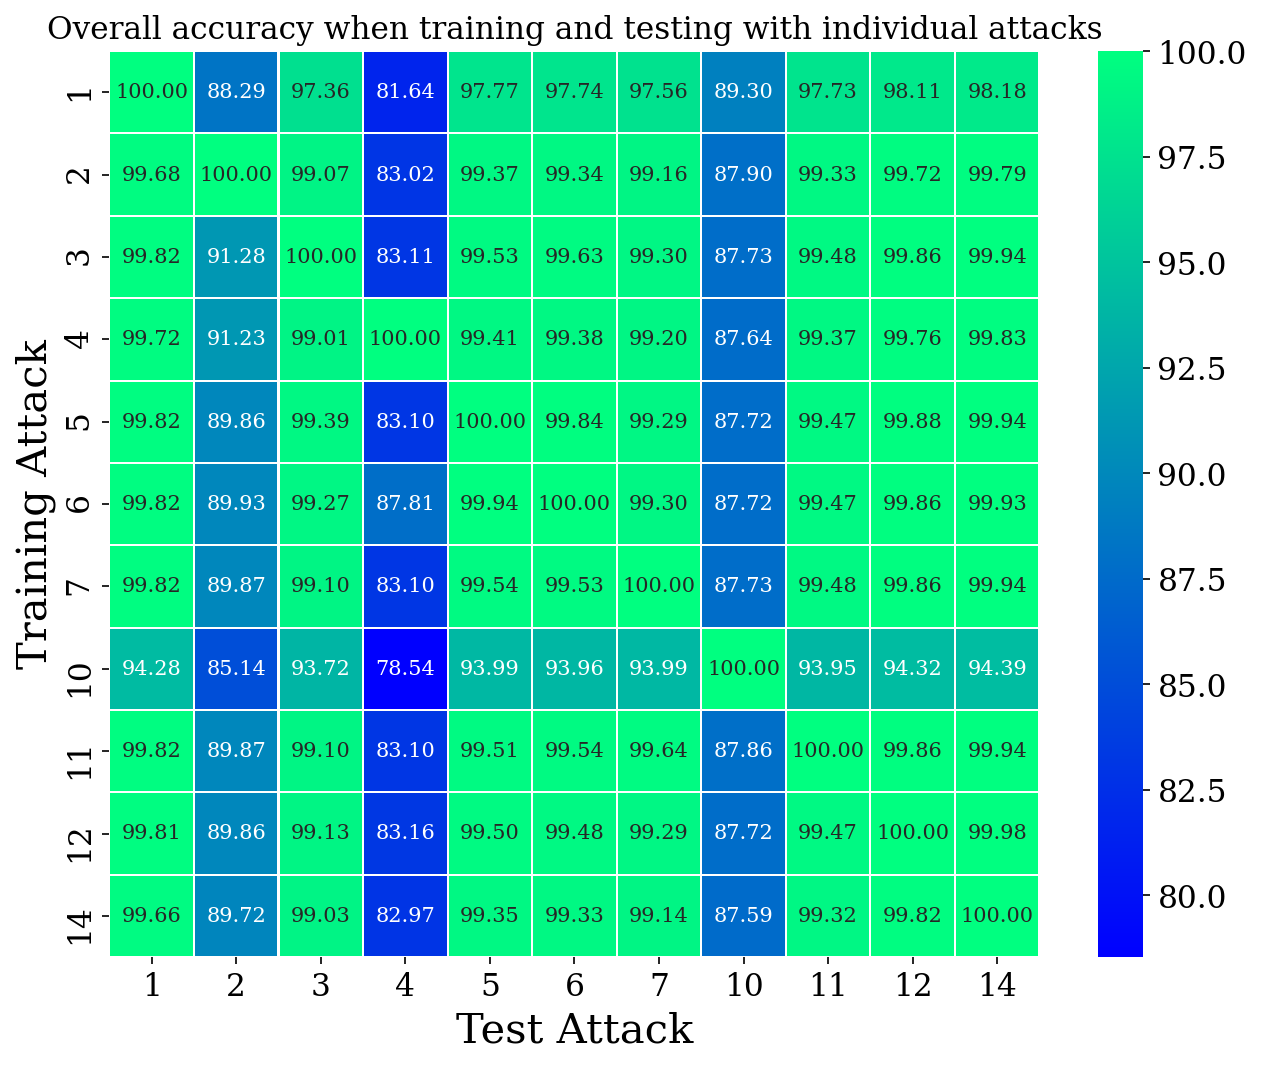

In [64]:
fig = plt.figure(figsize=(10, 8), dpi=150)

plt.rcParams["font.family"] = "serif"
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('axes', titlesize=15)  # fontsize of the figure title
# create some labels
attack_labels = [ "{0:d}".format(i) for i in attacks ]

# create a color map with random colors
#colmap = matplotlib.colors.ListedColormap(np.random.random((21,3)))
#colmap.colors[0] = [0,0,0]
import seaborn as sns
# this is the real plotting part
ax = fig.add_subplot(111)
sns.heatmap(accrd, linewidths=.5, annot=True, fmt='.2f', cmap='winter', ax=ax)


plt.xlabel('Test Attack')
plt.ylabel('Training Attack')
plt.title('Overall accuracy when training and testing with individual attacks')

plt.show()

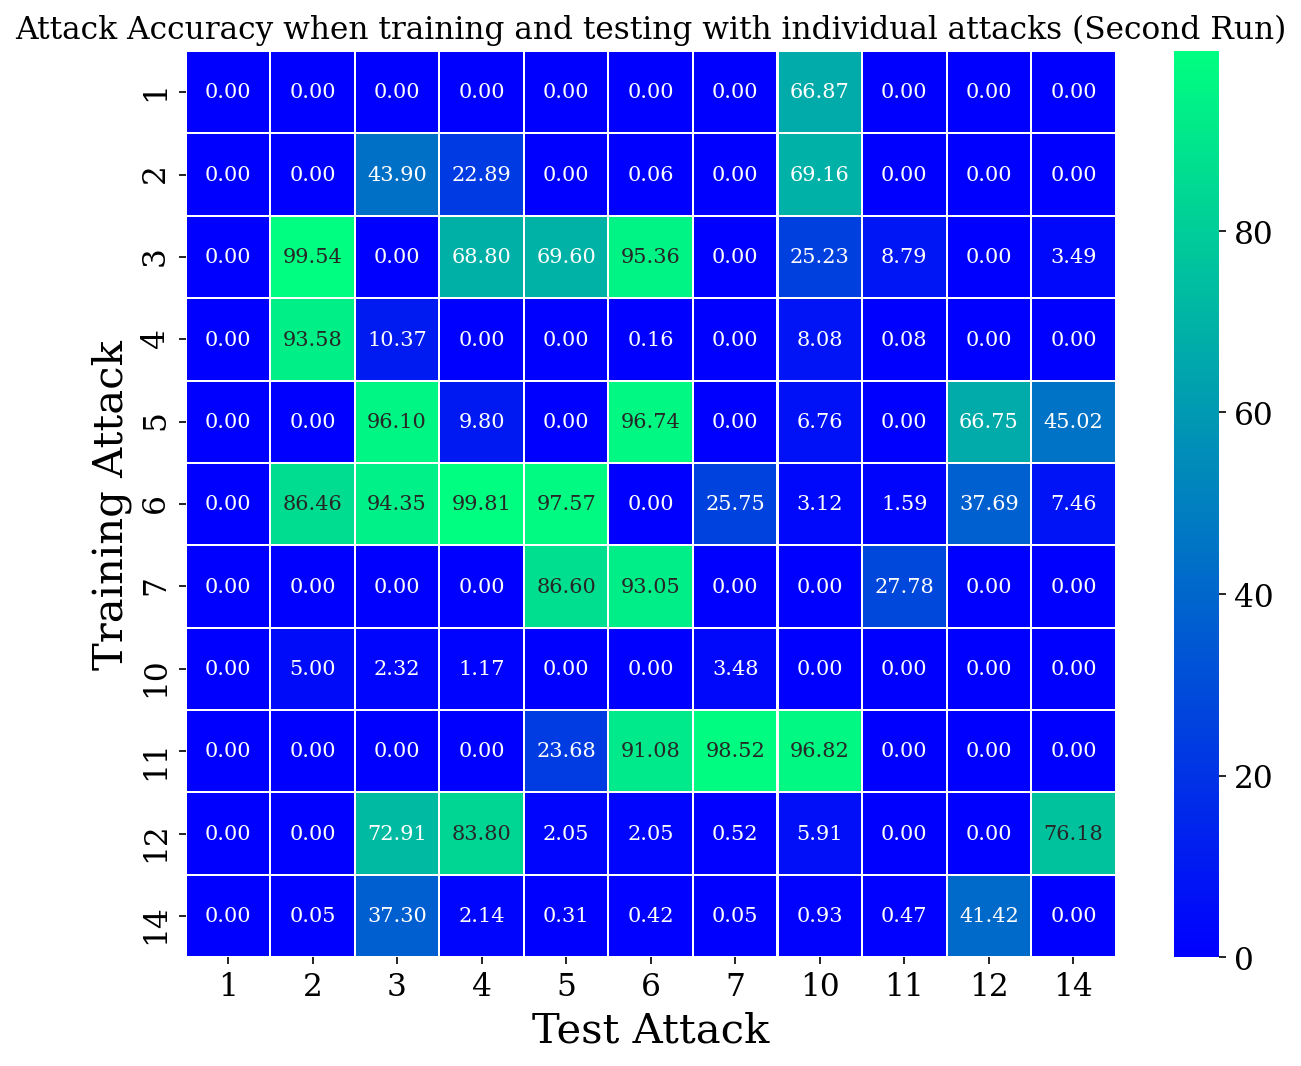

In [66]:
fig = plt.figure(figsize=(10, 8), dpi=150)

plt.rcParams["font.family"] = "serif"
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('axes', titlesize=15)  # fontsize of the figure title
# create some labels
attack_labels = [ "{0:d}".format(i) for i in attacks ]

# create a color map with random colors
#colmap = matplotlib.colors.ListedColormap(np.random.random((21,3)))
#colmap.colors[0] = [0,0,0]

# this is the real plotting part
ax = fig.add_subplot(111)
sns.heatmap(ataccrd, linewidths=.5, annot=True, fmt='.2f', cmap='winter', ax=ax)


plt.xlabel('Test Attack')
plt.ylabel('Training Attack')
plt.title('Attack Accuracy when training and testing with individual attacks (Second Run)')

plt.show()